# Starfysh tutorial on simulated ST dataset

**Azizi Lab**

Siyu He, Yinuo Jin

11-8-2022

This is a tutorial on a simple simulated ST [data](https://drive.google.com/drive/folders/14Zcz3h_IX50kFmZnKQwBI5y9PeyGz949?usp=share_link) (`simulated_ST_data_1`) generated from scRNA-seq data.


In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    !pip3 install scanpy
    #!pip3 install histomicstk
    from google.colab import drive
    drive.mount('/content/drive')
    import sys
    sys.path.append('/content/drive/MyDrive/SpatialModelProject/model_test_colab/')

In [2]:
import os
import numpy as np
import pandas as pd
import torch

In [3]:
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import rcParams

font_list = []
fpaths = matplotlib.font_manager.findSystemFonts()
for i in fpaths:
    try:
        f = matplotlib.font_manager.get_font(i)
        font_list.append(f.family_name)
    except RuntimeError:
        pass

font_list = set(font_list)
plot_font = 'Helvetica' if 'Helvetica' in font_list else 'FreeSans'

rcParams['font.family'] = plot_font
rcParams.update({'font.size': 10})
rcParams.update({'figure.dpi': 300})
rcParams.update({'figure.figsize': (3,3)})
rcParams.update({'savefig.dpi': 500})

import warnings
warnings.filterwarnings('ignore')

## Load starfysh

In [4]:
from starfysh import (utils,
                      plot_utils,
                      starfysh,
                      post_analysis,
                      AA
                     )

2022-11-08 22:18:46.657301: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-08 22:18:46.657321: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### (1). load data and marker genes:

File Input: 
- Spatial transcriptomics 
    - Count matrix: `adata`
    - (Optional): Paired histology & spot coordinates: `img`, `map_info`
    
- Annotated signatures (marker genes) for potential cell types: `gene_sig`

Starfysh is built upon scanpy and Anndata. The common ST/Visium data sample folder consists a expression count file (usually `filtered_feature_bc_matrix.h5`), and a subdirectory with corresponding H&E image and spatial information, as provided by Visium platform.

For example, our example ST data + marker genes has the following structure:
```
├── ../data
    tnbc_signature.csv

    ├── simulated_ST_data_1:
        \__ counts.st_synth.csv

        ├── (Optional) spatial:
            \__ aligned_fiducials.jpg
                detected_tissue_image.jpg
                scalefactors_json.json
                tissue_hires_image.png
                tissue_lowres_image.png
                tissue_positions_list.csv

```

For data that doesn't follow the common visium data structure (e.g. missing `filtered_featyur_bc_matrix.h5` or the given `.h5ad` count matrix file lacks spatial metadata), please construct the data as Anndata synthesizing information as the example simulated data shows:

In [5]:
# Loading expression counts and signature gene sets
data_path = '../data/'
sample_id = 'simulated_ST_data_1'
adata, adata_normed = utils.load_adata(data_folder=data_path,  # root data directory
                                       sample_id=sample_id,  # sample_id
                                       n_genes=2000  # number of highly variable genes to keep
                                      )


gene_sig = pd.read_csv(os.path.join('../data','tnbc_signature.csv'),index_col=0)
gene_sig = utils.filter_gene_sig(gene_sig,adata.to_df()) # filter out low-quality marker genes
gene_sig.head()

[2022-11-08 22:18:54] Preprocessing1: delete the mt and rp
[2022-11-08 22:18:55] Preprocessing2: Normalize
[2022-11-08 22:18:55] Preprocessing3: Logarithm
[2022-11-08 22:18:56] Preprocessing4: Find the variable genes


CAFs Cancer Epithelial Myeloid Normal Epithelial T-cells
0     DCN           SCGB2A2    C1QB             KRT14    CCL5
1  COL1A1              CD24     LYZ             KRT17    IL7R
2     LUM             MUCL1    C1QA               LTF    GNLY
3  COL1A2             KRT19    C1QC             KRT15    NKG7
4   SFRP2           SCGB1D2  TYROBP               PTN    CD3E

In [6]:
adata

AnnData object with n_obs × n_vars = 2551 × 2000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'highly_variable'

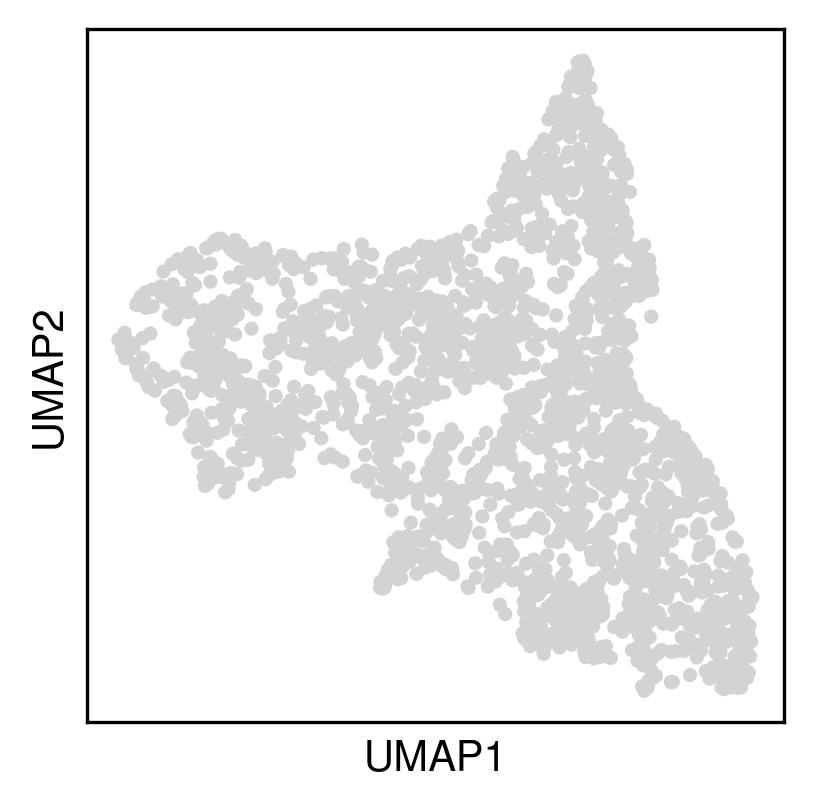

In [7]:
# Load spatial information
# [Note]:
# For simulated data without spatial coordinates, we replace them the umap location:
umap_df = utils.get_umap(adata, display=True)
map_info = utils.get_simu_map_info(umap_df)

### (2). Preprocessing (finding anchor spots)
- Identify anchor spot locations
For simulated data without spatial coordinates, we replace them the umap location:

Instantiate parameters for Starfysh model training:
- Raw & normalized counts after taking highly variable genes
- filtered signature genes
- library size & spatial smoothed library size (log-transformed)
- Anchor spot indices (`anchors_df`) for each cell type & their signature means (`sig_means`)

In [8]:
# Parameters for training
visium_args = utils.VisiumArguments(adata,
                                    adata_normed,
                                    gene_sig,
                                    map_info,
                                    n_anchors=60,
                                    window_size=3
                                   )

adata, adata_normed = visium_args.get_adata()

[2022-11-08 22:19:00] Filtering signatures not highly variable...
[2022-11-08 22:19:00] Smoothing library size by taking averaging with neighbor spots...


	 The number of original variable genes in the dataset (2000,)
	 The number of siganture genes in the dataset (146,)
	 After filter out some genes in the signature not in the var_names ... (135,)
	 After filter out some genes not highly expressed in the signature ... (135,)
	 Combine the varibale and siganture, the total unique gene number is ... 2000
	 The number of original variable genes in the dataset (2000,)
	 The number of siganture genes in the dataset (146,)
	 After filter out some genes in the signature not in the var_names ... (135,)
	 After filter out some genes not highly expressed in the signature ... (135,)
	 Combine the varibale and siganture, the total unique gene number is ... 2000


[2022-11-08 22:19:01] Retrieving & normalizing signature gene expressions...
[2022-11-08 22:19:02] Identifying anchor spots (highly expression of specific cell-type signatures)...


- Visualize the spatial data

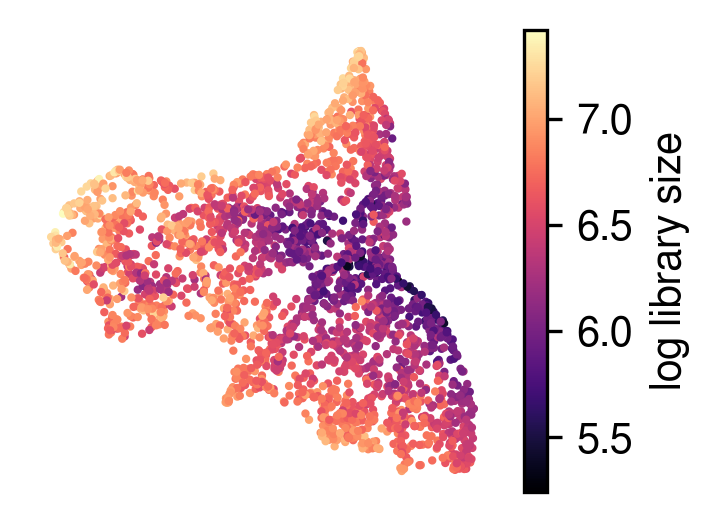

In [9]:
plot_utils.plot_spatial_feature(adata,
                                map_info,
                                visium_args.log_lib,
                                label='log library size'
                               )

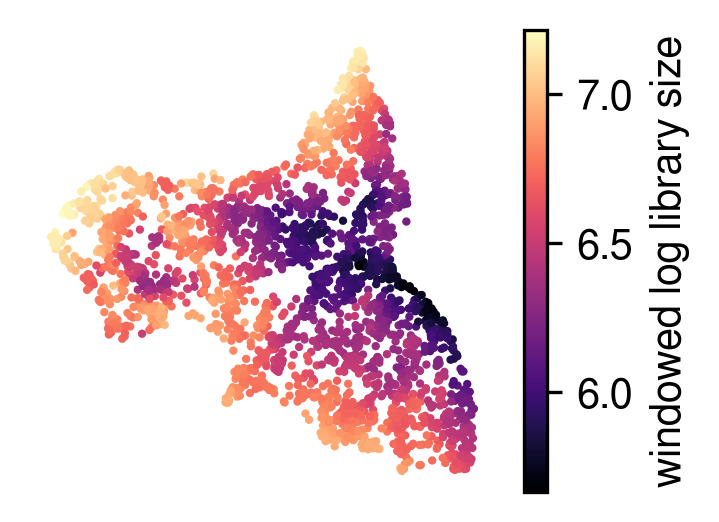

In [10]:
plot_utils.plot_spatial_feature(adata,
                                map_info,
                                visium_args.win_loglib,
                                label='windowed log library size',
                                )

plot raw gene expression:

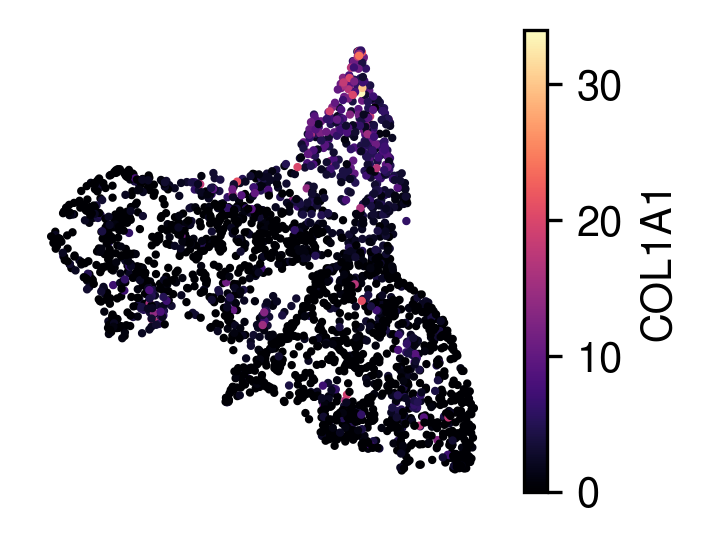

In [11]:
plot_utils.plot_spatial_gene(adata,
                             map_info,
                             gene_name='COL1A1'
                            )

- Visuliaze anchor spots

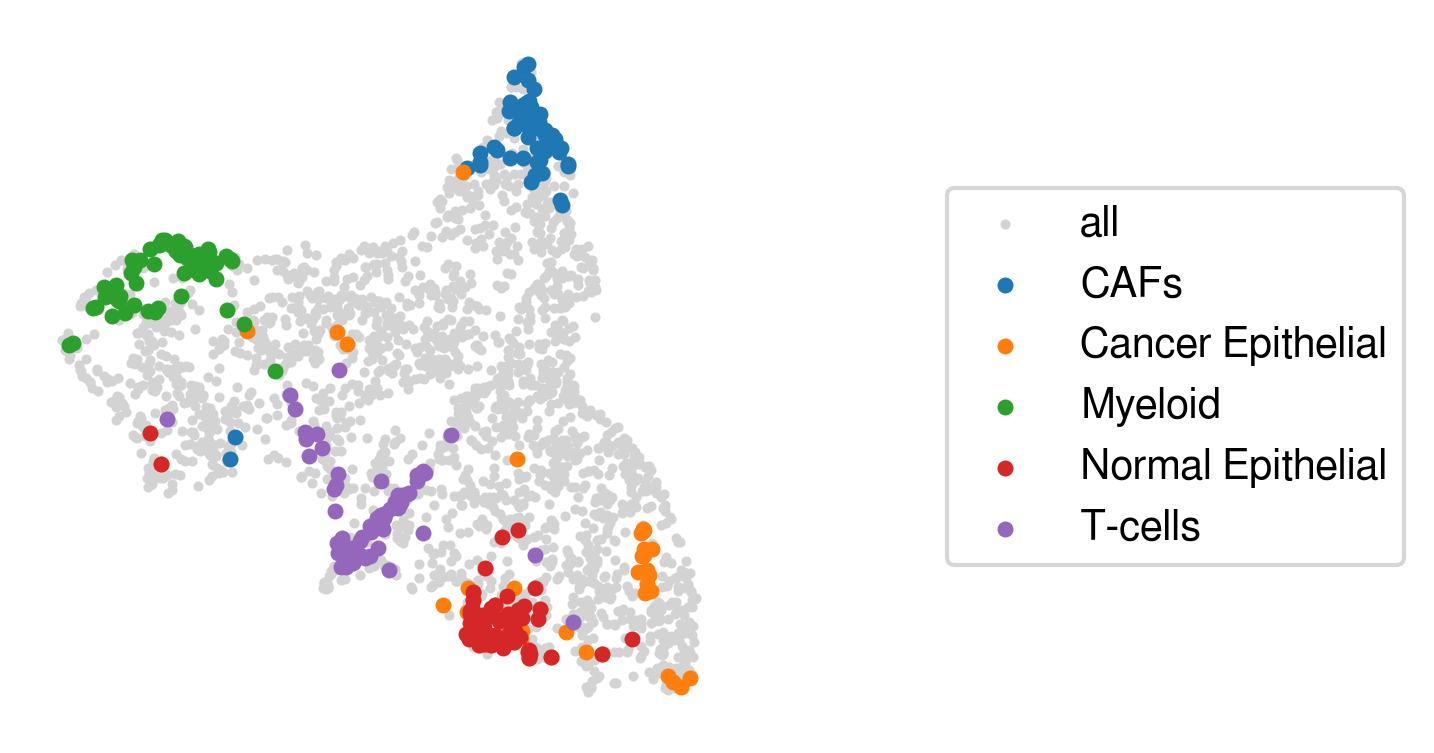

In [12]:
plot_utils.plot_anchor_spots(umap_df,
                             visium_args.pure_spots,
                             visium_args.sig_mean,
                             bbox_x=2
                            )

### (3). Optional: appending anchor spots with archetypal analysis
Overview:
If users don't provide annotated gene signature sets with cell types, Starfysh annotates cell types with archetypal analysis. The underlying assumption is that the geometric "extremes" are identified as the purest cell types, whereas all other spots are mixture of the "archetypes". If the users provide the gene signature sets, it's optional to apply AA to refine marker genes and update anchor spots for known cell types, and identify potential novel cell types / states. Here are the overview features provided by the AA steo:
- Finding archetypal spots & assign 1-1 mapping to their closest anchor spot neighbors
- Finding archetypal marker genes & append them to marker genes of annotated cell types
- Find novel cell type / cell states as the most distant archetypes


Note: <br>
- Intrinsic Dimension (ID) estimator is implemented to estimate the lower-bound for the number of archetypes $k$, followed by elbow method with iterations to identify the optimal $k$. By default, a [conditional number](https://scikit-dimension.readthedocs.io/en/latest/skdim.id.FisherS.html) is set as 30; if you believe there are potentially more / fewer cell types, please increase / decrease `cn` accordingly.

In [13]:
aa_model = AA.ArchetypalAnalysis(adata_orig=adata_normed)
archetype, arche_dict, major_idx, evs = aa_model.compute_archetypes(cn=10, converge=1e-2, display=False)
# (1). Find archetypal spots & archetypal clusters
arche_df = aa_model.find_archetypal_spots(major=True)

# (2). Find marker genes associated with each archetypal cluster
markers_df = aa_model.find_markers(n_markers=30, display=False)

# (3). Map archetypes to closest anchors (1-1 per cell type)
anchors_df = visium_args.get_anchors()
map_df, map_dict = aa_model.assign_archetypes(anchors_df)

# (4). Optional: Find the most distant archetypes that are not assigned to any annotated cell types
distant_arches = aa_model.find_distant_archetypes(anchors_df, n=3)

[2022-11-08 22:19:03] Computing intrinsic dimension to estimate k...


4 components are retained using conditional_number=10.00


[2022-11-08 22:19:03] Estimating lower bound of # archetype as 3...
[2022-11-08 22:19:11] Calculating UMAPs for counts + Archetypes...
[2022-11-08 22:19:18] Calculating UMAPs for counts + Archetypes...
[2022-11-08 22:19:23] 0.7838 variance explained by raw archetypes.
Merging raw archetypes within 20 NNs to get major archetypes
[2022-11-08 22:19:23] Finding 20 nearest neighbors for each archetype...
[2022-11-08 22:19:24] Finding 30 top marker genes for each archetype...


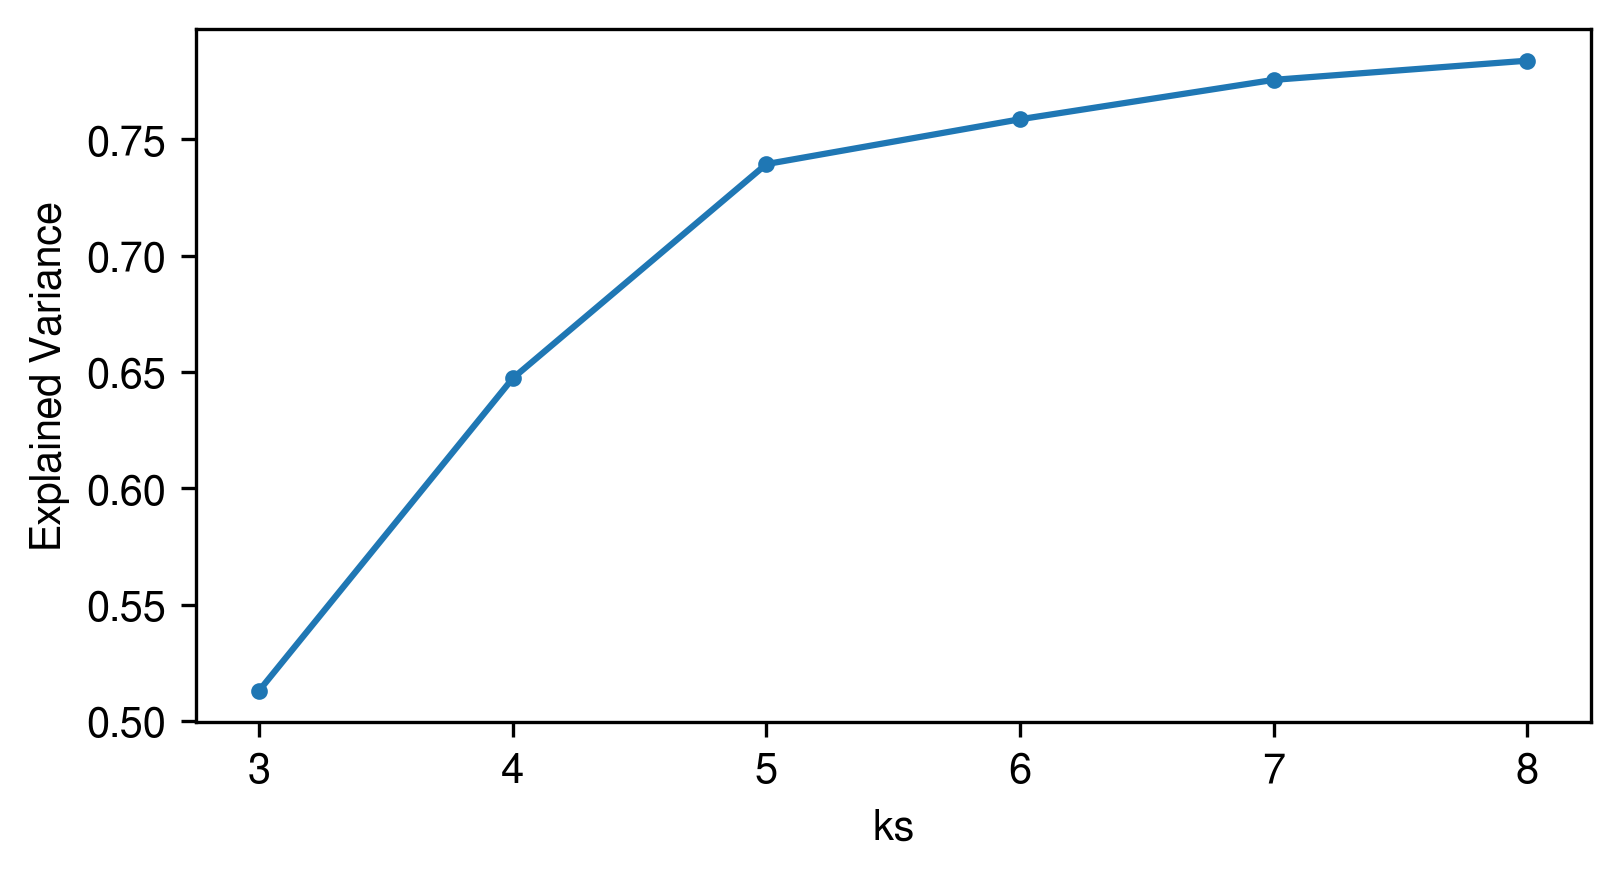

In [16]:
plot_utils.plot_evs(evs, kmin=aa_model.kmin)


- Visualize archetypes

(<Figure size 1200x800 with 1 Axes>,
 <Axes3DSubplot:xlabel='UMAP1', ylabel='UMAP2'>)

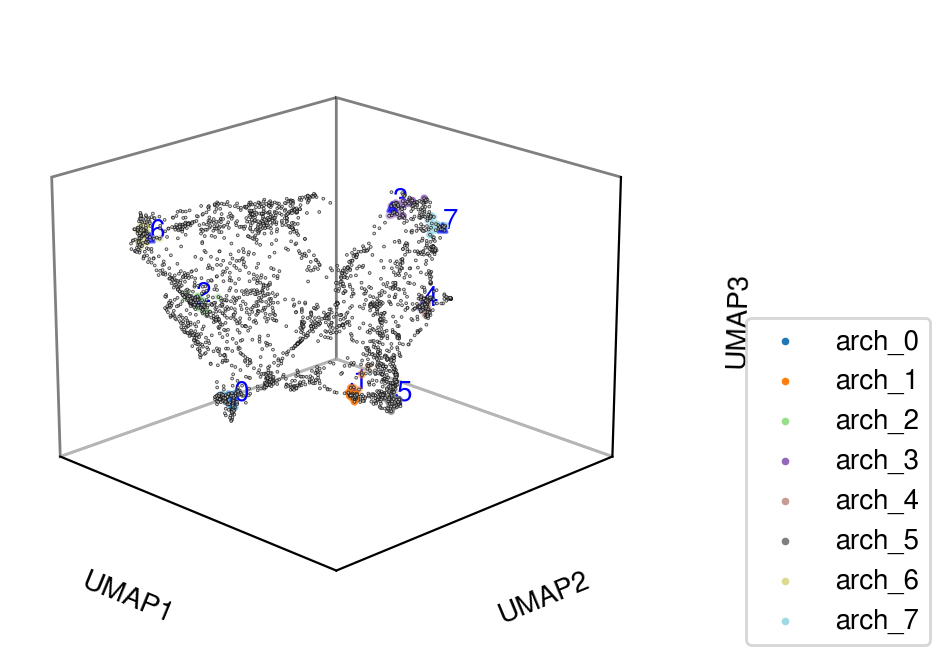

In [17]:
aa_model.plot_archetypes(do_3d=True, major=True, disp_cluster=True)

- Visualize overlapping ratio between archetypal & anchor spots:

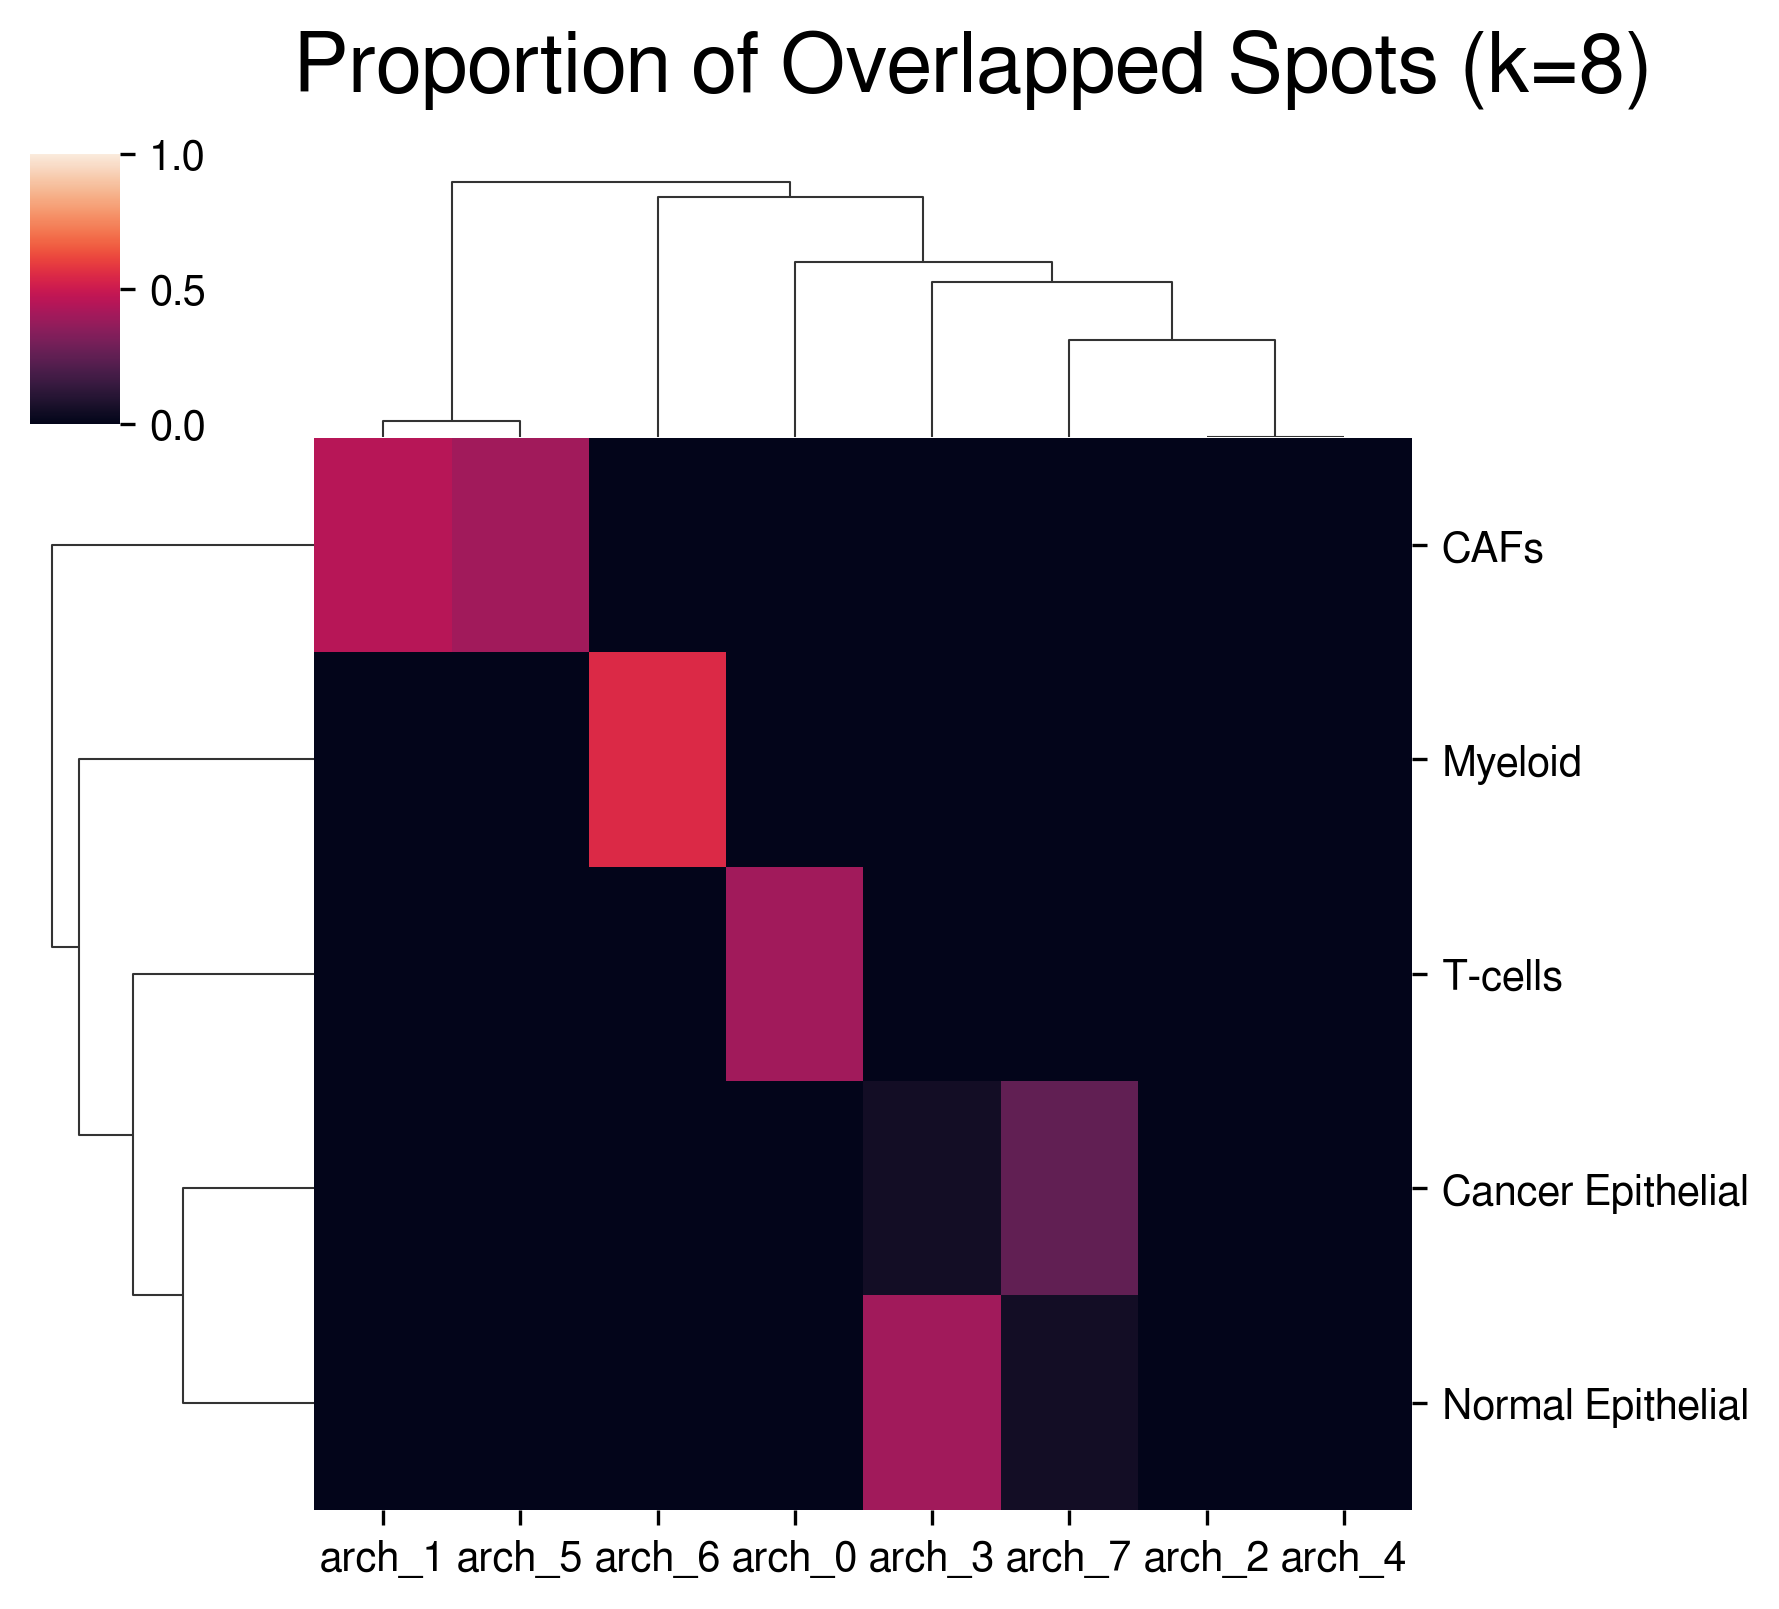

In [18]:
aa_model.plot_mapping(map_df)

- Application: appending marker genes
Append archetypal marker genes with the best-aligned anchors:


In [19]:
visium_args = utils.refine_anchors(
    visium_args,
    aa_model,
    map_info,
    n_genes=5,
    n_iters=1
)

[2022-11-08 22:30:13] Finding 50 top marker genes for each archetype...
[2022-11-08 22:30:15] Filtering signatures not highly variable...
[2022-11-08 22:30:15] Smoothing library size by taking averaging with neighbor spots...


Refining round 1...
appending 5 genes in arch_1 to CAFs...
appending 5 genes in arch_5 to CAFs...
appending 5 genes in arch_6 to Myeloid...
appending 5 genes in arch_3 to Normal Epithelial...
appending 5 genes in arch_0 to T-cells...
	 The number of original variable genes in the dataset (2000,)
	 The number of siganture genes in the dataset (157,)
	 After filter out some genes in the signature not in the var_names ... (145,)
	 After filter out some genes not highly expressed in the signature ... (145,)
	 Combine the varibale and siganture, the total unique gene number is ... 2000
	 The number of original variable genes in the dataset (2000,)
	 The number of siganture genes in the dataset (157,)
	 After filter out some genes in the signature not in the var_names ... (145,)
	 After filter out some genes not highly expressed in the signature ... (145,)
	 Combine the varibale and siganture, the total unique gene number is ... 2000


[2022-11-08 22:30:16] Retrieving & normalizing signature gene expressions...
[2022-11-08 22:30:16] Identifying anchor spots (highly expression of specific cell-type signatures)...


- Application: re-defining marker genes
In the annotated gene signatures provided by Wu et al., we found that the marker from
normal and cancer epithelials highly overlaps, thus creating confusions to separate those cell types.
Here we re-define markers and update new anchor spots for `Cancer Epithelials` from the
*most distant archetype* unmapped to any cell-type specific anchor spots:

In [20]:
gene_sig_updated = utils.append_sigs(
    gene_sig=visium_args.gene_sig,
    factor='Cancer Epithelial',
    sigs=markers_df[distant_arches[0]],
    n_genes=30
)

markers = gene_sig_updated['Cancer Epithelial']
markers = markers[~pd.isna(markers)][-30:]
gene_sig_updated.drop('Cancer Epithelial', axis=1, inplace=True)
gene_sig_updated['Cancer Epithelial'] = markers.reset_index(drop=True)
gene_sig_updated.sort_index(inplace=True, axis=1)


- Re-calculate anchor spots:

[2022-11-08 22:30:16] Filtering signatures not highly variable...
[2022-11-08 22:30:16] Smoothing library size by taking averaging with neighbor spots...


	 The number of original variable genes in the dataset (2000,)
	 The number of siganture genes in the dataset (157,)
	 After filter out some genes in the signature not in the var_names ... (148,)
	 After filter out some genes not highly expressed in the signature ... (148,)
	 Combine the varibale and siganture, the total unique gene number is ... 2000
	 The number of original variable genes in the dataset (2000,)
	 The number of siganture genes in the dataset (157,)
	 After filter out some genes in the signature not in the var_names ... (148,)
	 After filter out some genes not highly expressed in the signature ... (148,)
	 Combine the varibale and siganture, the total unique gene number is ... 2000


[2022-11-08 22:30:18] Retrieving & normalizing signature gene expressions...
[2022-11-08 22:30:18] Identifying anchor spots (highly expression of specific cell-type signatures)...


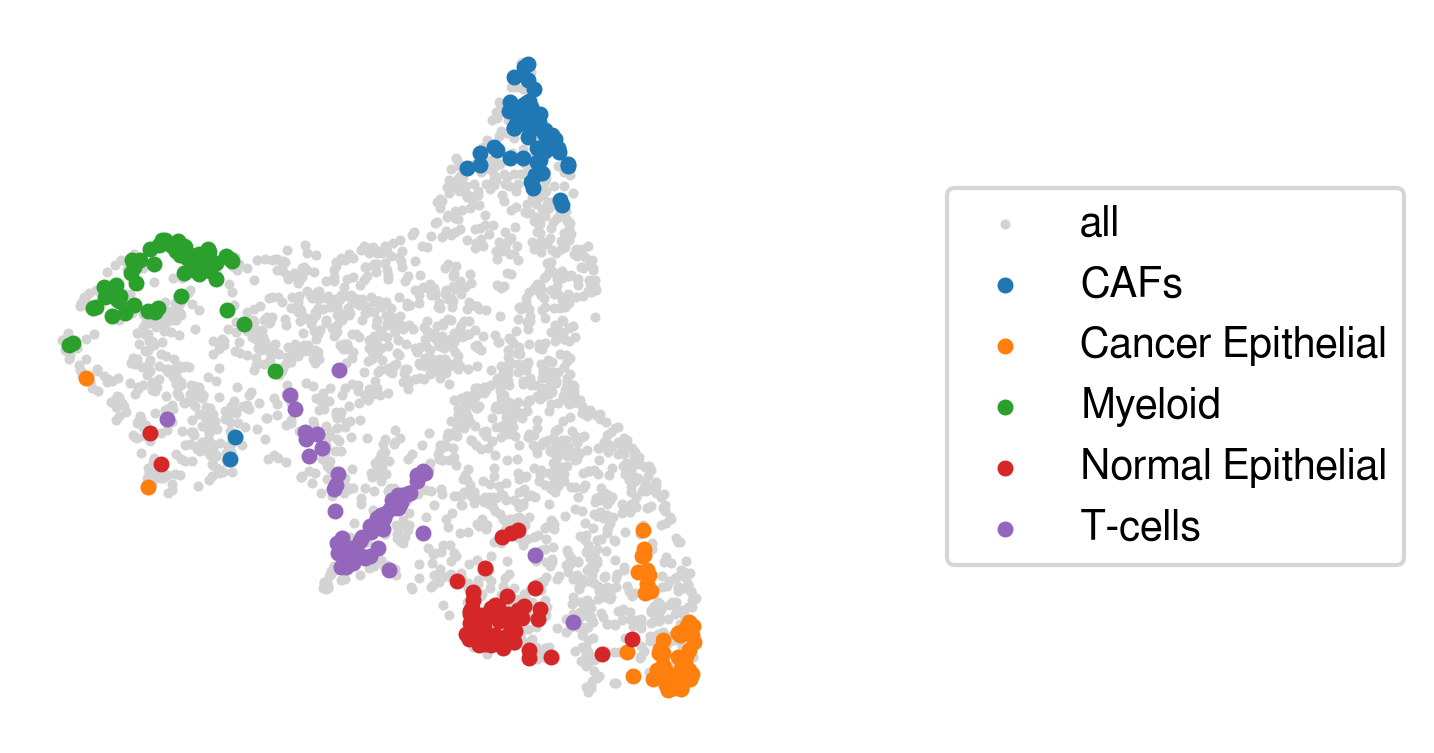

In [21]:
visium_args = utils.VisiumArguments(visium_args.adata,
                                    visium_args.adata_norm,
                                    gene_sig_updated,
                                    map_info,
                                    n_anchors=60,
                                    window_size=3
                                   )


plot_utils.plot_anchor_spots(umap_df,
                             visium_args.pure_spots,
                             visium_args.sig_mean,
                             bbox_x=2
                            )



Compared with the previous visualization, we observe that `Cancer` & `Normal` epithelial anchor spots are separated this time.


##  Run starfysh

We perform `n_repeat` random restarts and select the best model with lowest loss for parameter `c` (inferred cell-type proportions):

### (1). Model parameters

In [22]:
n_repeats = 3
epochs = 100
patience = 10
device = torch.device('cuda')

### (2). Model training

In [23]:
# Run models
model, loss = utils.run_starfysh(visium_args,
                                 n_repeats=n_repeats,
                                 epochs=epochs,
                                 patience=patience,
                                 poe=False,
                                 device=device
                                )

[2022-11-08 22:30:18] Running Starfysh with 3 restarts, choose the model with best parameters...
[2022-11-08 22:30:18]  ===  Restart Starfysh 1 === 

[2022-11-08 22:30:20] Initializing model parameters...
[2022-11-08 22:30:38] Epoch[10/100], train_loss: 655.5768, train_reconst: 510.0832, train_z: 18.5745,train_c: 103.1167,train_n: 23.8024
[2022-11-08 22:30:58] Epoch[20/100], train_loss: 602.1007, train_reconst: 479.2338, train_z: 18.2735,train_c: 82.0321,train_n: 22.5614
[2022-11-08 22:31:16] Epoch[30/100], train_loss: 581.5545, train_reconst: 461.5871, train_z: 18.0160,train_c: 81.7311,train_n: 20.2203
[2022-11-08 22:31:33] Epoch[40/100], train_loss: 547.4213, train_reconst: 449.3862, train_z: 18.1031,train_c: 62.1278,train_n: 17.8043
[2022-11-08 22:31:51] Epoch[50/100], train_loss: 534.5642, train_reconst: 440.8028, train_z: 18.5148,train_c: 59.1030,train_n: 16.1436
[2022-11-08 22:32:09] Epoch[60/100], train_loss: 533.4422, train_reconst: 435.5213, train_z: 18.9099,train_c: 64.2547,t

### (3). Downstream analysis

#### Extract Starfysh inference

In [24]:
inference_outputs, generative_outputs, px = starfysh.model_eval(model,
                                                                adata,
                                                                visium_args.sig_mean,
                                                                device,
                                                                visium_args.log_lib,
                                                               )
u = post_analysis.get_z_umap(inference_outputs,map_info)
u = pd.DataFrame(u,columns=['umap1','umap2'])
u.index = map_info.index

####  Visualize starfysh deconvolution results

##### Gene sig mean vs. inferred prop

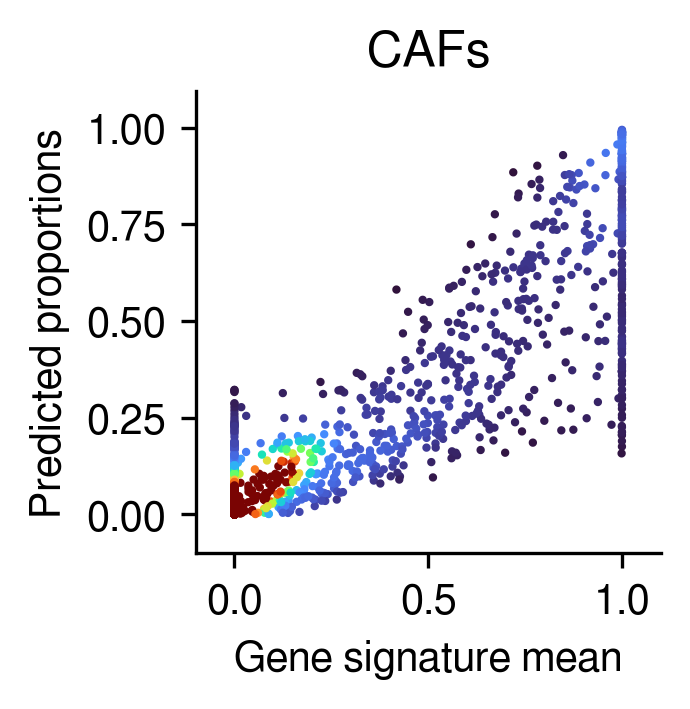

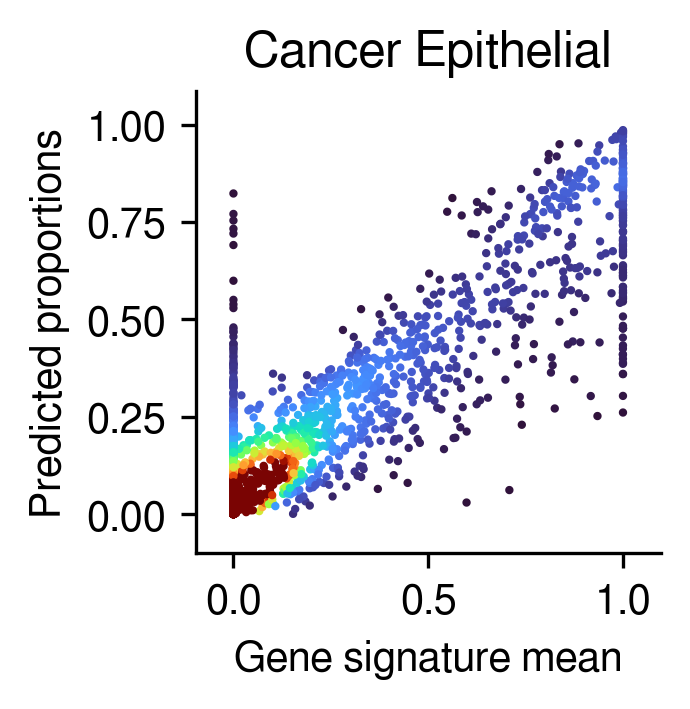

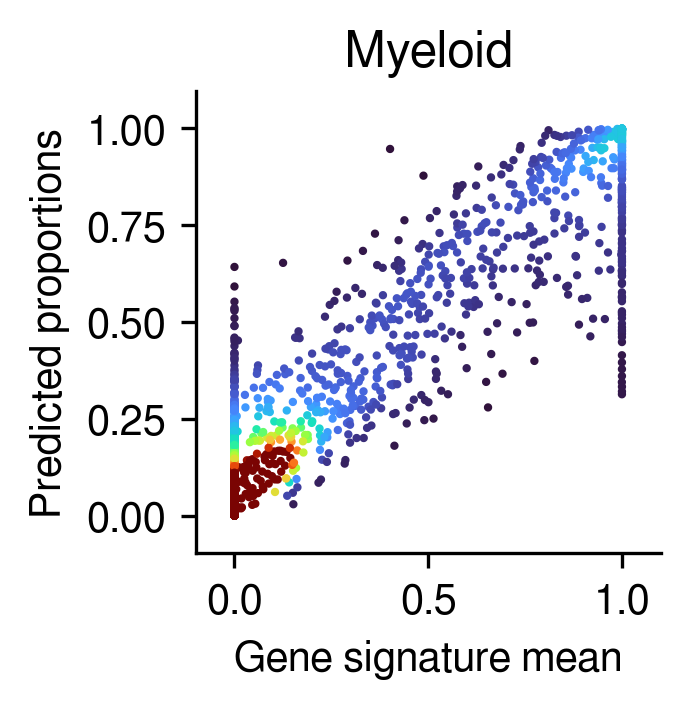

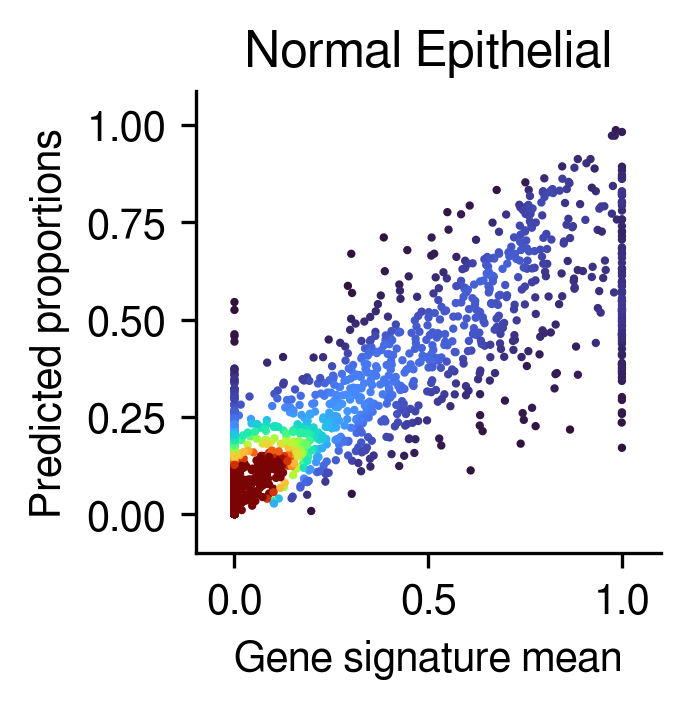

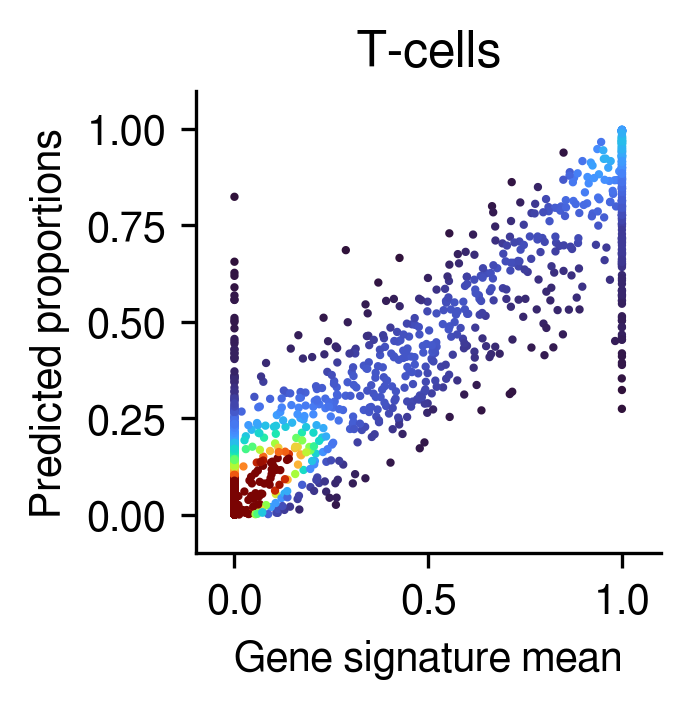

In [25]:
for idx in range(5):
    post_analysis.gene_mean_vs_inferred_prop(inference_outputs,
                                             visium_args,
                                             idx=idx ## the order of the cell types
                                            )




##### Compare the deconvolution against the ground-truth proportions

In [26]:
member = pd.read_csv(os.path.join('../data','simulated_ST_data_1','members.st_synth.csv'),index_col=0)
proportions = pd.read_csv(os.path.join('../data','simulated_ST_data_1','proportions.st_synth.csv'),index_col=0)

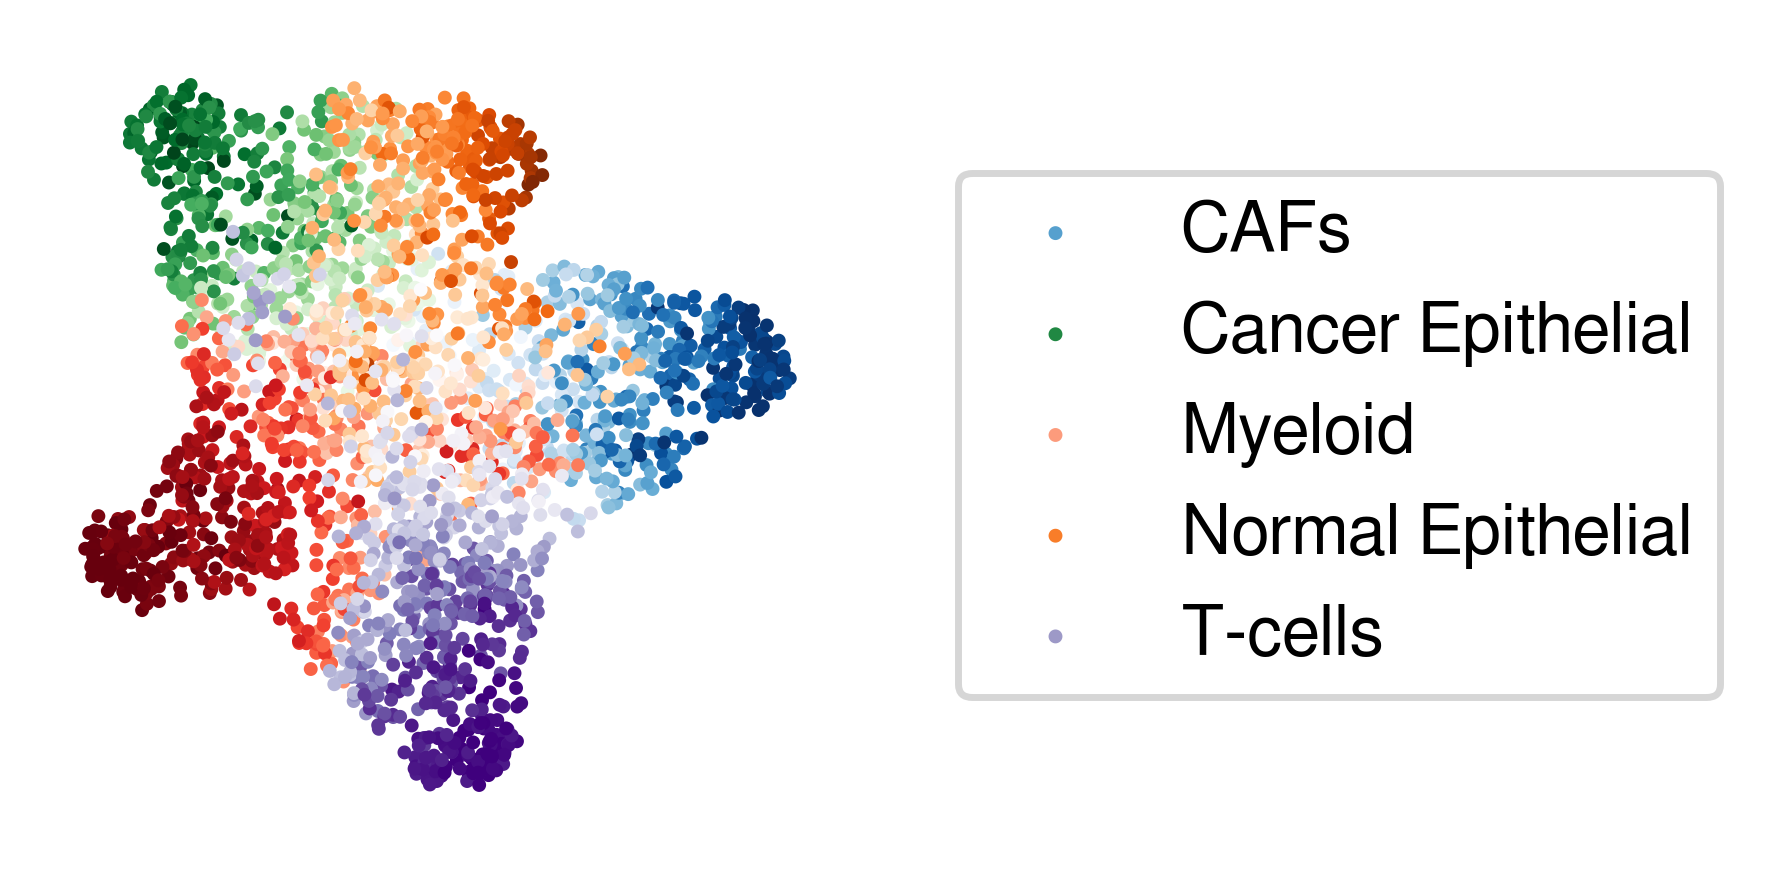

In [27]:
post_analysis.plot_type_all(inference_outputs,np.array(u),proportions)

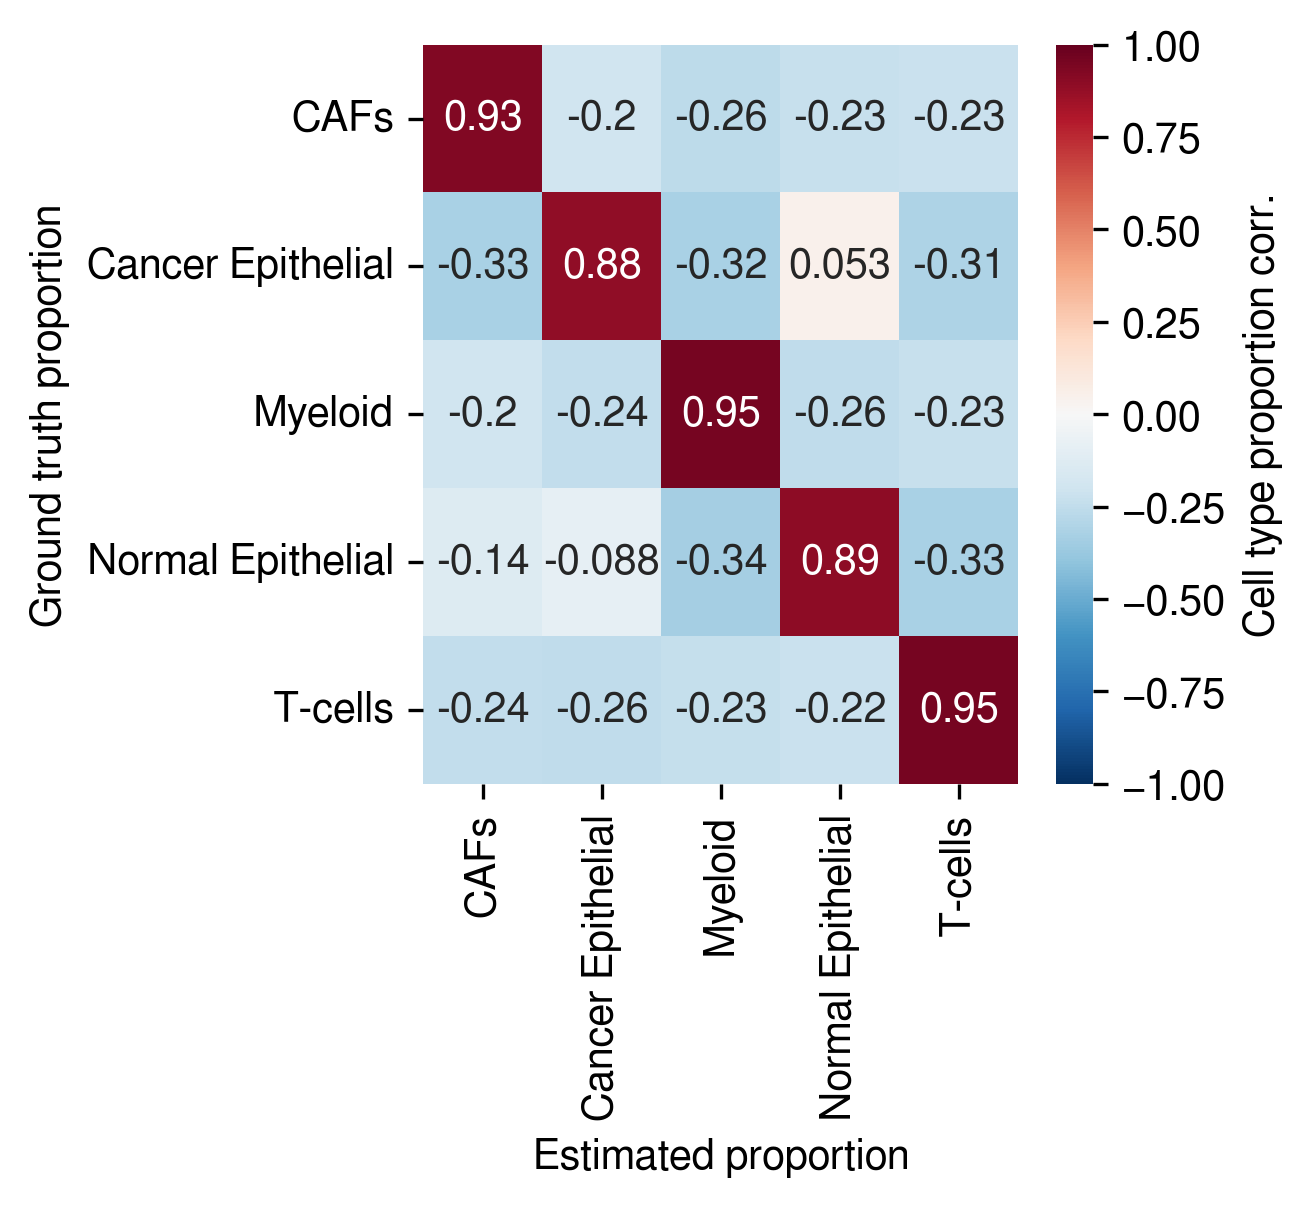

In [28]:
post_analysis.get_corr_map(inference_outputs,proportions)

#### Spatial visualizations:

##### Inferred density

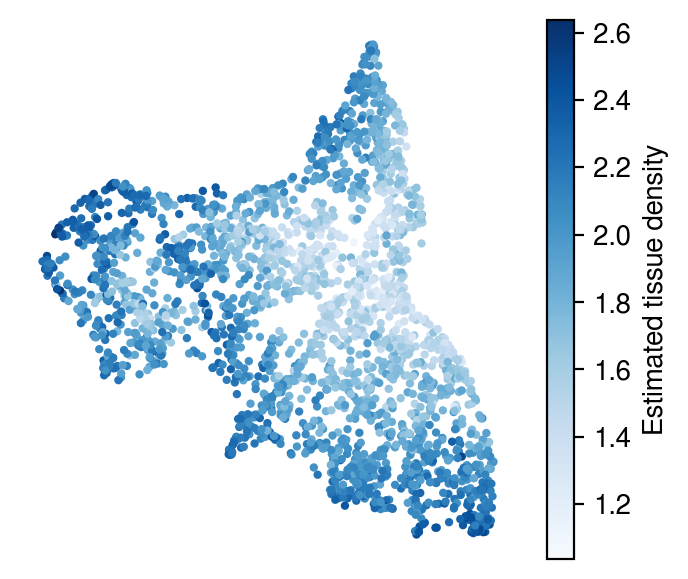

In [29]:
plot_utils.pl_spatial_inf_feature(adata,
                                  map_info,
                                  inference_outputs,
                                  feature='ql_m',
                                  idx=0,
                                  plt_title='',
                                  label='Estimated tissue density',
                                  s=4,
                                  cmap='Blues'
                                  #vmax=3
                                 )

##### Inferred proportions

Cell-type: `Cancer epithelial`

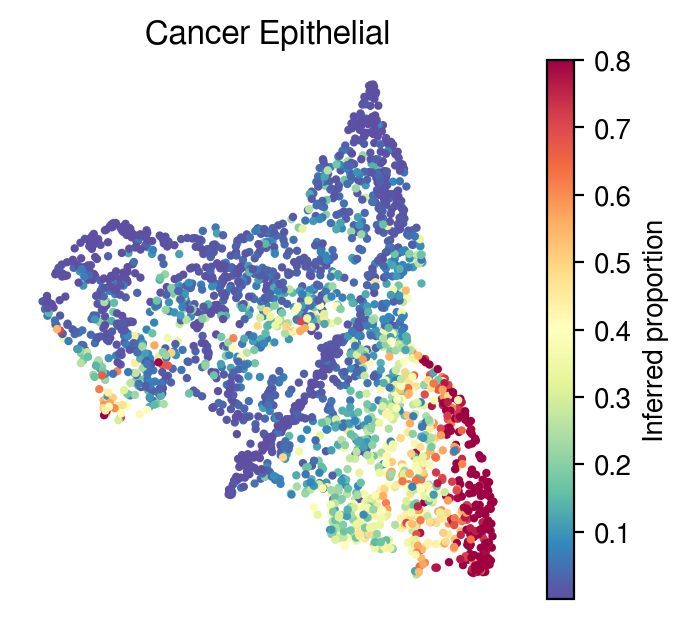

In [30]:
idx=1
plot_utils.pl_spatial_inf_feature(adata,
                   map_info,
                   inference_outputs,
                   feature='qc_m',
                   idx=idx,
                   plt_title=gene_sig.columns[idx],
                   label='Inferred proportion',
                   s=4,
                   vmax=0.8
                   )

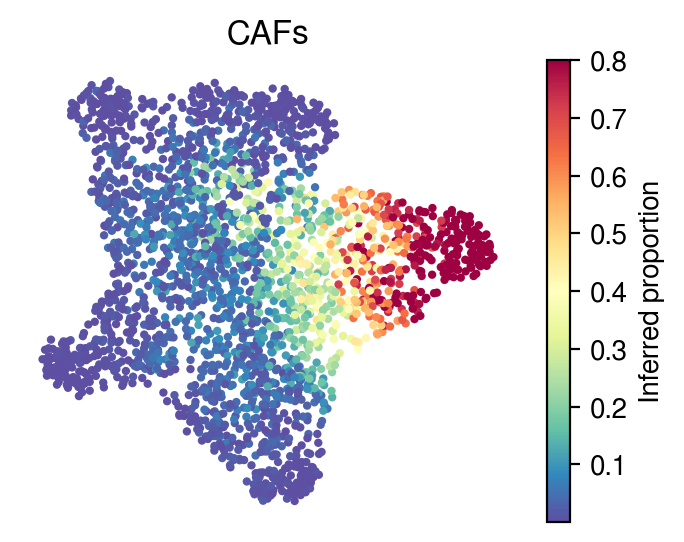

In [31]:
idx=0
plot_utils.pl_umap_feature(adata,
                   u,
                   inference_outputs,
                   feature='qc_m',
                   idx=idx,
                   plt_title=gene_sig.columns[idx],
                   label='Inferred proportion',
                   s=4,
                   vmax=0.8)


##### Inferred cell-type specific expressions for each spot

In [32]:
pred_exp = {}
for i, label in enumerate(gene_sig.columns):
    pred_exp[label] = starfysh.model_ct_exp(model,
                                            adata,
                                            visium_args.sig_mean_znorm, 
                                            device,
                                            visium_args.log_lib,
                                            ct_idx=i
                                           ).tolist()


Plot example spot-level expression of `TMEM33` from *Activated CD8+*:

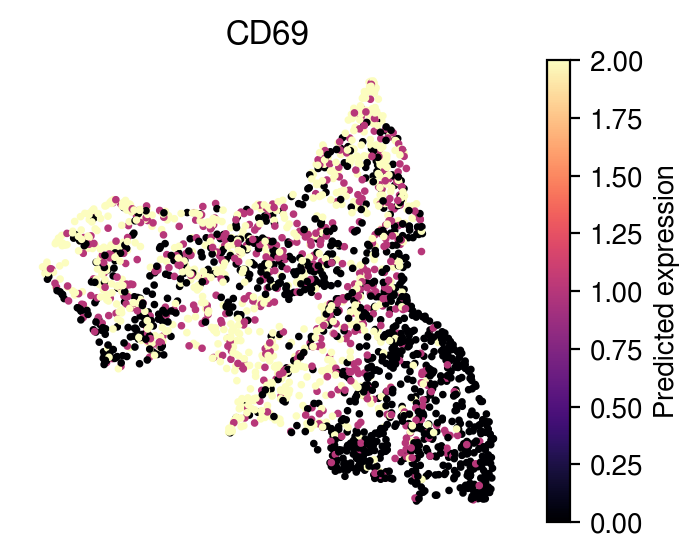

In [33]:
idx = list(adata.var_names[adata.var['highly_variable']]).index('CD69')
plot_utils.pl_spatial_inf_gene(adata,
                   map_info,
                   feature=np.asarray(pred_exp['Cancer Epithelial']),
                   idx= idx,
                   plt_title=list(adata.var_names[adata.var['highly_variable']])[idx],
                   label='Predicted expression',
                   s=3,
                   vmax=2)
